In [62]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
smsspam = pd.read_csv('../data/smsspam.csv')
spam = pd.read_csv('../data/spam.csv')
tsp = pd.read_csv('../data/tsp.csv')

In [3]:
class GBayes:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        _data = x
        _data['label'] = y
        self.classes = np.unique(y)
        
        # prior
        self.class_probabilities = _data.groupby('label').size() / len(_data)
        
        # posterior
        self.means = _data.groupby('label').mean()
        self.std = _data.groupby('label').std()

    def calculate_probability(self, x, mean, std):
        exp = np.exp(-((x - mean) ** 2 / (2 * std ** 2)))
        if not exp:
            exp += 1e-5
        return (1 / (np.sqrt(2 * np.pi) * std)) * exp
    
    def class_probability_one(self, row):
        
        row_class = np.ones(len(self.classes))
        for cls in self.classes:
            for column in self.means:
                row_class[cls] *= self.calculate_probability(row[column], self.means.iloc[cls][column],
                                                             self.std.iloc[cls][column])
        return row_class
                
    def predict_row(self, x):
        pfc = self.class_probability_one(x)
        pcf = np.ones(len(self.classes))
        
        total_prob = (pfc * self.class_probabilities).sum()
        
        pcf = (pfc * self.class_probabilities) / total_prob
            
        prediction = pcf.argmax()
        if prediction < 0:
            prediction = np.random.randint(0, 2)

        return pfc, pcf, prediction
    
    def predict(self, x):
        y = []
        prob_1 = []
        for i in range(len(x)):
            pfc, pcf, prediction = self.predict_row(x.iloc[i])
            prob_1.append(pcf[1])
            y.append(prediction)
        return y, prob_1

In [4]:
def accuracy(y_pred, y_true):
    return (y_pred == y_pred).sum() / len(y_pred)

In [12]:
x, y = spam.drop('label', axis=1), spam.label
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train = pd.DataFrame(x_train, columns=spam.drop('label', axis=1).columns)
x_test = pd.DataFrame(x_test, columns=spam.drop('label', axis=1).columns)

In [13]:
gb = GBayes()

In [14]:
gb.fit(x_train, y_train)

In [15]:
y_pred, prob = gb.predict(x_test)

In [16]:
fpr, tpr, _ = roc_curve(y_test, prob)

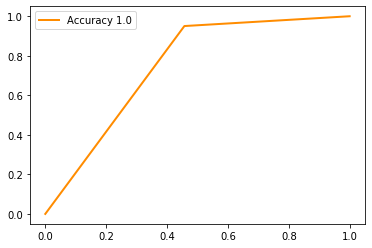

In [17]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Accuracy {accuracy(y_test, y_pred)}')
plt.legend()

In [154]:
class MBayes:
    def __init__(self):
        pass
    
    def fit(self, x, y):
        self._data = x
        self._data['label'] = y
        self.classes = np.unique(y)
        
        self.n_doc = len(x)
        self.n_doc_c = self._data.groupby('label').size()
        self.prior = np.log(self.n_doc_c / self.n_doc)
        self.train()
        
    def tokenize(self, x):
        x = ' '.join([ps.stem(i.lower()) for i in x.split() if len(ps.stem(i.lower())) > 1])
        return x
        
    def train(self):
        self._data.text = self._data.text.apply(self.tokenize)
        self.vectorizer = CountVectorizer()
        self.vectorizer.fit_transform(self._data.text)
        self.vocab = self.vectorizer.get_feature_names()
        
        self.likelihood = {}
        for cls in self.classes:
            self.vectorizer = CountVectorizer()
            x = self.vectorizer.fit_transform(self._data.loc[self._data.label == cls].text)
            matrix = x.toarray()
            cls_vocab = self.vectorizer.get_feature_names()
            self.likelihood[cls] = {}
            for i, word in enumerate(cls_vocab):
                word_count = sum(matrix[:, i])
                self.likelihood[cls][word] = np.log((word_count + 1) / (matrix.sum() + len(self.vocab)))
                
    def predict_row(self, x):
        class_sum = np.zeros(len(self.classes))
        for i, cls in enumerate(self.classes):
            class_sum[i] = self.prior.loc[cls]
            for word in x.split():
                if (word in self.vocab) and (word in self.likelihood[cls]):
                    class_sum[i] += self.likelihood[cls][word]
            class_sum /= sum(class_sum)
        return class_sum, np.argmax(class_sum)
    
    def predict(self, x):
        y_pred = []
        probs = []
        for row in x.text:
            text = self.tokenize(row)
            p, y = self.predict_row(text)
            y_pred.append(y)
            probs.append(p)
        return y_pred, probs

In [155]:
x, y = smsspam.drop('label', axis=1), smsspam.label
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train = pd.DataFrame(x_train, columns=smsspam.drop('label', axis=1).columns)
x_test = pd.DataFrame(x_test, columns=smsspam.drop('label', axis=1).columns)

In [156]:
mb = MBayes()

In [157]:
mb.fit(x_train, y_train)

In [158]:
y_pred, prob = mb.predict(x_test)

In [159]:
prob

[array([-0.01207399,  1.01207399]),
 array([-0.0209203,  1.0209203]),
 array([-0.00685125,  1.00685125]),
 array([-0.01018654,  1.01018654]),
 array([-0.03140296,  1.03140296]),
 array([-0.01367663,  1.01367663]),
 array([-0.01881666,  1.01881666]),
 array([-0.01641123,  1.01641123]),
 array([-0.0734504,  1.0734504]),
 array([-0.00692558,  1.00692558]),
 array([-0.02269938,  1.02269938]),
 array([-0.02661767,  1.02661767]),
 array([-0.01787144,  1.01787144]),
 array([-0.00854456,  1.00854456]),
 array([-0.03158103,  1.03158103]),
 array([-0.00755078,  1.00755078]),
 array([-0.00639468,  1.00639468]),
 array([-0.14234335,  1.14234335]),
 array([-0.04895664,  1.04895664]),
 array([-0.03209136,  1.03209136]),
 array([-0.00763457,  1.00763457]),
 array([-0.05009781,  1.05009781]),
 array([-0.01017693,  1.01017693]),
 array([-0.00849109,  1.00849109]),
 array([-0.02185161,  1.02185161]),
 array([-0.01120244,  1.01120244]),
 array([-0.02439117,  1.02439117]),
 array([-0.01192081,  1.01192081

In [168]:
y_test_int = lambda x: 1 if x == 'ham' else 0

In [169]:
y_test_int = [y_test_int(i) for i in y_test]

In [171]:
fpr, tpr, _ = roc_curve(y_test_int, pd.DataFrame(prob)[1].values)

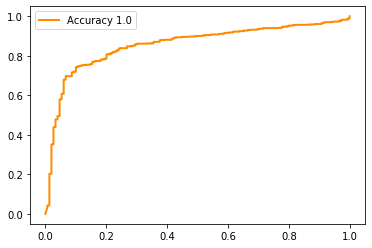

In [172]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Accuracy {accuracy(y_test, y_pred)}')
plt.legend()